In [1]:
import os
import pandas as pd
import shutil, os
import numpy as np
# import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

import tensorflow as tf
# from tensorflow.keras.layers import Dropout, Flatten, Dense, InputLayer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau
# from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.backend import clear_session

import keras
from keras import backend as K
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam
import CNN_Baseline as baseline
import CNN_C as dropout
import CNN_D as batchN
import CNN_E as mobnet
import CNN_E as vgg16

In [2]:
# Choose which GPU to use - HEX SERVER ONLY. Go to https://hex.cs.bath.ac.uk/usage for current usage
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

# Prevent GPU memory overflow
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
#import multiprocessing
INPUT_SHAPE = (128, 128, 3) # Image Dimensions
BATCH_SIZE = 128
DROPOUT_RATE = 0.5
EPOCHS = 30
LR = 0.0001 # Learning Rate
REG_STRENGTH = 0.01 # Regularization Strength
# NFOLDS = 5 # No of folds for cross validation
WORKERS = 16 #multiprocessing.cpu_count()-1 #32 # Multithreading no of threads
MAXQ = 10 # Max Queue size for multithreading
THRES = [0.2] * 17 # Threshold for truth value of label, applied on sigmoid output.

In [4]:
DATASET_PATH = 'dataset/'
TRAIN_PATH = DATASET_PATH + 'train_file'
TEST_PATH = DATASET_PATH + 'test_file'

TRAIN_CSV_PATH = DATASET_PATH + 'train_label.csv'
TEST_CSV_PATH = DATASET_PATH + 'test_label.csv'

In [5]:
df_train = pd.read_csv(TRAIN_CSV_PATH)
df_test = pd.read_csv(TEST_CSV_PATH)

df_train['image_name'] = df_train['image_name'].astype(str)
df_test['image_name'] = df_test['image_name'].astype(str)

df_train['tags'] = df_train['tags'].apply(lambda x: x.split(' '))
df_test['tags'] = df_test['tags'].apply(lambda x: x.split(' '))

# print(df_train.head())
# print()
# print(df_test.head())

In [6]:
X_train_files_o = np.array(df_train['image_name'].tolist()) # filenames
X_train_files_o.reshape((X_train_files_o.shape[0], 1))
y_train_o = np.array(df_train['tags'].tolist()) # image tags (ground truth)

<ipython-input-6-0991b910e4b8>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_train_o = np.array(df_train['tags'].tolist()) # image tags (ground truth)


In [7]:
# check labels in tags and how many there are
tags = df_train['tags'].values

flat_list = [item for sublist in tags for item in sublist]
tags_unique, tags_count = np.unique(flat_list, return_counts=True)
labels = list(tags_unique)

print(labels)
print()
print(len(labels), "unique tags")

['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down', 'clear', 'cloudy', 'conventional_mine', 'cultivation', 'habitation', 'haze', 'partly_cloudy', 'primary', 'road', 'selective_logging', 'slash_burn', 'water']

17 unique tags


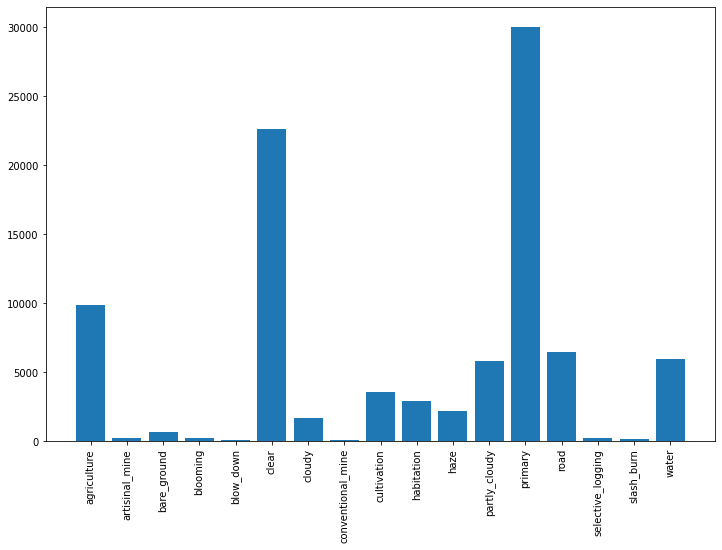

In [8]:
# Distribution of the labels

plt.figure(figsize=(12, 8))
            
plt.bar(range(len(tags_count)), list(tags_count), align='center')
plt.xticks(range(len(tags_count)), list(labels), rotation=90)

plt.show()

In [9]:
# Define learning curve and evaluation metric (f-2 Beta score):

def learning_curve(model_fit, key='acc', ylim=(0.8, 1.01)):
    plt.figure(figsize=(12,6))
    plt.plot(model_fit.history[key])
    plt.plot(model_fit.history['val_' + key])
    plt.title('Learning Curve')
    plt.ylabel(key.title())
    plt.xlabel('Epoch')
    plt.ylim(ylim)
    plt.legend(['train', 'test'], loc='best')
    plt.show()

# F-Beta Score
def fbeta_score_K(y_true, y_pred):
    beta = 2
    beta_squared = beta ** 2
    tp = K.sum(y_true * y_pred) + K.epsilon()
    fp = K.sum(y_pred) - tp
    fn = K.sum(y_true) - tp

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    result = (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())
    return result

from sklearn.metrics import fbeta_score

def calc_acc(ypred,df_test):
    result = np.array(y_pred)
    result = pd.DataFrame(result, columns = labels)
    preds = []
    for i in range(result.shape[0]):
        a = result.iloc[[i]]
        a = a.apply(lambda x: x > THRES, axis=1)
        a = a.transpose()
        a = a.loc[a[i] == True]
        ' '.join(list(a.index))
        preds.append(' '.join(list(a.index)))
    df_test['pred_tags'] = preds
    test = df_test['tags']
    pred = df_test['pred_tags'].apply(lambda x: x.split(' '))
    
    from sklearn.preprocessing import MultiLabelBinarizer
    
    mlb = MultiLabelBinarizer()
    test = mlb.fit_transform(test)
    pred = mlb.transform(pred)
    score = fbeta_score(test,pred,beta=2,average='weighted')
    return score

def plot(result,file):
    train_history = pd.DataFrame(result)

    train_history.to_csv(file, sep=',')
    plt.plot(train_history['fbeta_score_K'])
    plt.plot(train_history['val_fbeta_score_K'])
    plt.title('model accuracy')
    plt.ylabel('fbeta_score_K')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    plt.plot(train_history['loss'])
    plt.plot(train_history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [10]:
def data_generator(X_train_files_o, y_train_o,base_flg):
    X_train_files, X_val_files, y_train, y_val = train_test_split(X_train_files_o, y_train_o, test_size=0.2, random_state=0)

    train_df = pd.DataFrame(list(zip(X_train_files, y_train)), columns = ['image_name', 'tags'])
    val_df = pd.DataFrame(list(zip(X_val_files, y_val)), columns = ['image_name', 'tags'])

    train_df['tags'] = train_df['tags']
    val_df['tags'] = val_df['tags']
    
    if base_flg == 1:
        train_datagen = ImageDataGenerator(
            rescale=1./255
            )
    else:
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            vertical_flip=True
            )
        
    train_generator = train_datagen.flow_from_dataframe(
        train_df,
        directory=TRAIN_PATH,
        x_col='image_name',
        y_col='tags',
        target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        classes=labels,
        )

    val_datagen = ImageDataGenerator(
        rescale=1./255
        )

    val_generator = val_datagen.flow_from_dataframe(
        val_df,
        directory=TRAIN_PATH,
        x_col='image_name',
        y_col='tags',
        target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        classes=labels,
        )

    test_datagen = ImageDataGenerator(
        rescale=1./255
        )

    test_generator = test_datagen.flow_from_dataframe(
        df_test,
        directory=TEST_PATH,
        x_col='image_name',
        y_col='tags',
        target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        classes=labels,
        shuffle=False,
        )
    return train_generator,val_generator,test_generator

### CNN Baseline

In [11]:
train_generator, val_generator, test_generator = data_generator(X_train_files_o, y_train_o,1)
model_path = 'CNN_Baseline_weights' + '.h5'


adam = Adam(learning_rate=LR)

cnn_base_model = baseline.create_model()

clear_session()

cnn_base_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[fbeta_score_K])

callbacks = [
    ModelCheckpoint(model_path, monitor='val_fbeta_score_K', save_best_only=True, mode='max'),
    ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, mode='min', min_lr=0.000001)
]

history = cnn_base_model.fit(train_generator, epochs=EPOCHS, validation_data=val_generator, callbacks=callbacks,
                   workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)

print('here', history.history.keys())


cnn_base_model.load_weights(model_path)

y_pred = cnn_base_model.predict(test_generator, workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)

Found 25906 validated image filenames belonging to 17 classes.
Found 6477 validated image filenames belonging to 17 classes.
Found 8096 validated image filenames belonging to 17 classes.
Epoch 1/30
203/203 [==============================] - 40s 166ms/step - loss: 0.3757 - fbeta_score_K: 0.4816 - val_loss: 0.2313 - val_fbeta_score_K: 0.5806
Epoch 2/30
203/203 [==============================] - 32s 156ms/step - loss: 0.2245 - fbeta_score_K: 0.5972 - val_loss: 0.2044 - val_fbeta_score_K: 0.6302
Epoch 3/30
203/203 [==============================] - 33s 161ms/step - loss: 0.2042 - fbeta_score_K: 0.6387 - val_loss: 0.1954 - val_fbeta_score_K: 0.6641
Epoch 4/30
203/203 [==============================] - 33s 157ms/step - loss: 0.1932 - fbeta_score_K: 0.6575 - val_loss: 0.1849 - val_fbeta_score_K: 0.6716
Epoch 5/30
203/203 [==============================] - 31s 152ms/step - loss: 0.1832 - fbeta_score_K: 0.6785 - val_loss: 0.1758 - val_fbeta_score_K: 0.6807
Epoch 6/30
203/203 [==================

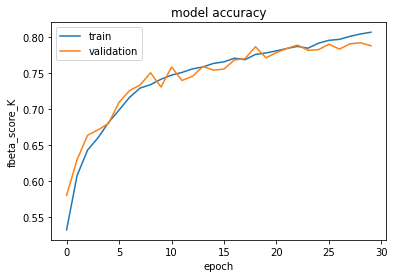

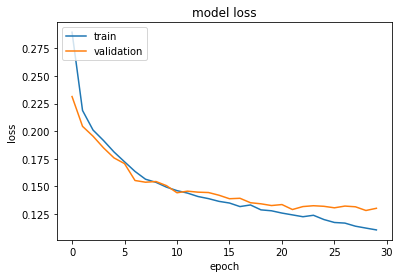

Test Accuracy Score 0.8686416255509899


In [12]:
plot(history.history,'CNN_Baseline_train_history.csv')
print("Test Accuracy Score",calc_acc(y_pred,df_test))

### CNN_Baseline + Haze removed data

In [15]:
DATASET_PATH = 'dataset-haze-removed/'
TRAIN_PATH = DATASET_PATH + 'train_file'
TEST_PATH = DATASET_PATH + 'test_file'

TRAIN_CSV_PATH = DATASET_PATH + 'train_label.csv'
TEST_CSV_PATH = DATASET_PATH + 'test_label.csv'

In [16]:
df_train = pd.read_csv(TRAIN_CSV_PATH)
df_test = pd.read_csv(TEST_CSV_PATH)

df_train['image_name'] = df_train['image_name'].astype(str)
df_test['image_name'] = df_test['image_name'].astype(str)

df_train['tags'] = df_train['tags'].apply(lambda x: x.split(' '))
df_test['tags'] = df_test['tags'].apply(lambda x: x.split(' '))

X_train_files_o = np.array(df_train['image_name'].tolist()) # filenames
X_train_files_o.reshape((X_train_files_o.shape[0], 1))
y_train_o = np.array(df_train['tags'].tolist()) # image tags (ground truth)

# check labels in tags and how many there are
tags = df_train['tags'].values

flat_list = [item for sublist in tags for item in sublist]
tags_unique, tags_count = np.unique(flat_list, return_counts=True)
labels = list(tags_unique)

print(labels)
print()
print(len(labels), "unique tags")

['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down', 'clear', 'cloudy', 'conventional_mine', 'cultivation', 'habitation', 'haze', 'partly_cloudy', 'primary', 'road', 'selective_logging', 'slash_burn', 'water']

17 unique tags


<ipython-input-16-2c16ded3c3cd>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_train_o = np.array(df_train['tags'].tolist()) # image tags (ground truth)


In [17]:
train_generator, val_generator, test_generator = data_generator(X_train_files_o, y_train_o,1)
model_path = 'CNN_Baseline_haze_weights' + '.h5'


adam = Adam(learning_rate=LR)

cnn_base_model = baseline.create_model()

clear_session()

cnn_base_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[fbeta_score_K])

callbacks = [
    ModelCheckpoint(model_path, monitor='val_fbeta_score_K', save_best_only=True, mode='max'),
    ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, mode='min', min_lr=0.000001)
]

history = cnn_base_model.fit(train_generator, epochs=EPOCHS, validation_data=val_generator, callbacks=callbacks,
                   workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)

print('here', history.history.keys())


cnn_base_model.load_weights(model_path)

y_pred = cnn_base_model.predict(test_generator, workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)

Found 25906 validated image filenames belonging to 17 classes.
Found 6477 validated image filenames belonging to 17 classes.
Found 8096 validated image filenames belonging to 17 classes.
Epoch 1/30
203/203 [==============================] - 35s 161ms/step - loss: 0.3707 - fbeta_score_K: 0.4916 - val_loss: 0.2289 - val_fbeta_score_K: 0.5819
Epoch 2/30
203/203 [==============================] - 33s 154ms/step - loss: 0.2167 - fbeta_score_K: 0.6076 - val_loss: 0.1928 - val_fbeta_score_K: 0.6852
Epoch 3/30
203/203 [==============================] - 34s 162ms/step - loss: 0.1837 - fbeta_score_K: 0.6771 - val_loss: 0.1704 - val_fbeta_score_K: 0.6940
Epoch 4/30
203/203 [==============================] - 36s 170ms/step - loss: 0.1694 - fbeta_score_K: 0.7070 - val_loss: 0.1586 - val_fbeta_score_K: 0.7243
Epoch 5/30
203/203 [==============================] - 36s 168ms/step - loss: 0.1586 - fbeta_score_K: 0.7256 - val_loss: 0.1556 - val_fbeta_score_K: 0.7237
Epoch 6/30
203/203 [==================

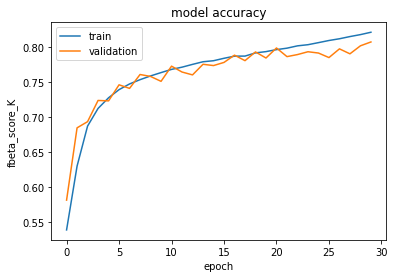

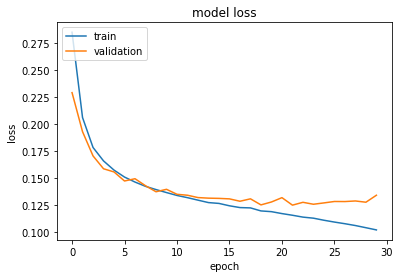

Test Accuracy Score 0.8735644258505267


In [18]:
plot(history.history,'CNN_Baseline_haze_train_history.csv')
print("Test Accuracy Score",calc_acc(y_pred,df_test))

### A. CNN_Baseline + Haze Removal + Data Augmentation

In [69]:
# DATASET_PATH = 'dataset-haze-removed/'
# TRAIN_PATH = DATASET_PATH + 'train_file'
# TEST_PATH = DATASET_PATH + 'test_file'

# TRAIN_CSV_PATH = DATASET_PATH + 'train_label.csv'
# TEST_CSV_PATH = DATASET_PATH + 'test_label.csv'

In [19]:
# df_train = pd.read_csv(TRAIN_CSV_PATH)
# df_test = pd.read_csv(TEST_CSV_PATH)

# df_train['image_name'] = df_train['image_name'].astype(str)
# df_test['image_name'] = df_test['image_name'].astype(str)

# df_train['tags'] = df_train['tags'].apply(lambda x: x.split(' '))
# df_test['tags'] = df_test['tags'].apply(lambda x: x.split(' '))

# X_train_files_o = np.array(df_train['image_name'].tolist()) # filenames
# X_train_files_o.reshape((X_train_files_o.shape[0], 1))
# y_train_o = np.array(df_train['tags'].tolist()) # image tags (ground truth)

# # check labels in tags and how many there are
# tags = df_train['tags'].values

# flat_list = [item for sublist in tags for item in sublist]
# tags_unique, tags_count = np.unique(flat_list, return_counts=True)
# labels = list(tags_unique)

# print(labels)
# print()
# print(len(labels), "unique tags")

In [20]:
train_generator, val_generator, test_generator = data_generator(X_train_files_o, y_train_o,0)

model_path = 'CNN_A_weights' + '.h5'

adam = Adam(learning_rate=LR)

cnn_base_model = baseline.create_model()

clear_session()

cnn_base_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[fbeta_score_K])

callbacks = [
    ModelCheckpoint(model_path, monitor='val_fbeta_score_K', save_best_only=True, mode='max'),
    ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, mode='min', min_lr=0.000001)
]

history = cnn_base_model.fit(train_generator, epochs=EPOCHS, validation_data=val_generator, callbacks=callbacks,
                   workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)

print('here', history.history.keys())


cnn_base_model.load_weights(model_path)

y_pred = cnn_base_model.predict(test_generator, workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)

Found 25906 validated image filenames belonging to 17 classes.
Found 6477 validated image filenames belonging to 17 classes.
Found 8096 validated image filenames belonging to 17 classes.
Epoch 1/30
203/203 [==============================] - 45s 209ms/step - loss: 0.3746 - fbeta_score_K: 0.4931 - val_loss: 0.2411 - val_fbeta_score_K: 0.5795
Epoch 2/30
203/203 [==============================] - 42s 200ms/step - loss: 0.2248 - fbeta_score_K: 0.5949 - val_loss: 0.1997 - val_fbeta_score_K: 0.6623
Epoch 3/30
203/203 [==============================] - 40s 190ms/step - loss: 0.1896 - fbeta_score_K: 0.6633 - val_loss: 0.1822 - val_fbeta_score_K: 0.6984
Epoch 4/30
203/203 [==============================] - 42s 196ms/step - loss: 0.1751 - fbeta_score_K: 0.6939 - val_loss: 0.1666 - val_fbeta_score_K: 0.6975
Epoch 5/30
203/203 [==============================] - 41s 194ms/step - loss: 0.1657 - fbeta_score_K: 0.7114 - val_loss: 0.1623 - val_fbeta_score_K: 0.7373
Epoch 6/30
203/203 [==================

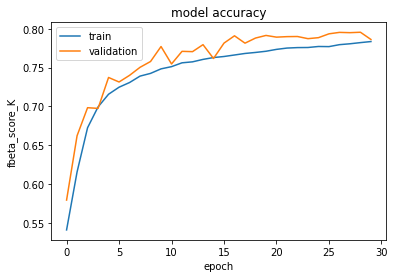

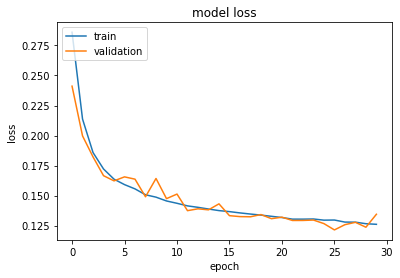

Test Accuracy Score 0.8783697505809839


In [22]:
plot(history.history,'CNN_A_train_history.csv')
print("Test Accuracy Score",calc_acc(y_pred,df_test))

### B. CNN_Baseline + Haze Removal + Data Augmentation + Early Stopping

In [23]:
train_generator, val_generator, test_generator = data_generator(X_train_files_o, y_train_o,0)

model_path = 'CNN_B_weights' + '.h5'


adam = Adam(learning_rate=LR)

cnn_base_model = baseline.create_model()

clear_session()

cnn_base_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[fbeta_score_K])

callbacks = [
    ModelCheckpoint(model_path, monitor='val_fbeta_score_K', save_best_only=True, mode='max'),
    ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, mode='min', min_lr=0.000001),
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5),
]

history = cnn_base_model.fit(train_generator, epochs=EPOCHS, validation_data=val_generator, callbacks=callbacks,
                   workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)

print('here', history.history.keys())

cnn_base_model.load_weights(model_path)

y_pred = cnn_base_model.predict(test_generator, workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)

Found 25906 validated image filenames belonging to 17 classes.
Found 6477 validated image filenames belonging to 17 classes.
Found 8096 validated image filenames belonging to 17 classes.
Epoch 1/30
203/203 [==============================] - 42s 197ms/step - loss: 0.3724 - fbeta_score_K: 0.4918 - val_loss: 0.2434 - val_fbeta_score_K: 0.5707
Epoch 2/30
203/203 [==============================] - 42s 198ms/step - loss: 0.2334 - fbeta_score_K: 0.5850 - val_loss: 0.1990 - val_fbeta_score_K: 0.6715
Epoch 3/30
203/203 [==============================] - 42s 199ms/step - loss: 0.1903 - fbeta_score_K: 0.6654 - val_loss: 0.1925 - val_fbeta_score_K: 0.7049
Epoch 4/30
203/203 [==============================] - 43s 197ms/step - loss: 0.1756 - fbeta_score_K: 0.6934 - val_loss: 0.1643 - val_fbeta_score_K: 0.7159
Epoch 5/30
203/203 [==============================] - 41s 196ms/step - loss: 0.1666 - fbeta_score_K: 0.7111 - val_loss: 0.1632 - val_fbeta_score_K: 0.7428
Epoch 6/30
203/203 [==================

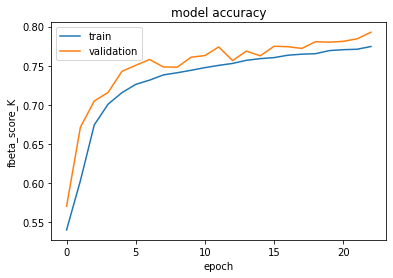

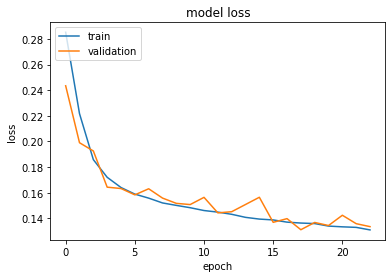

Test Accuracy Score 0.8609988843587223


In [26]:
plot(history.history,'CNN_B_train_history.csv')
print("Test Accuracy Score",calc_acc(y_pred,df_test))

### C. CNN_Baseline + Haze Removal + Data Augmentation + Drop out

In [27]:
train_generator, val_generator, test_generator = data_generator(X_train_files_o, y_train_o,0)

model_path = 'CNN_C_weights' + '.h5'


adam = Adam(learning_rate=LR)

cnn_dropout_model = dropout.create_model()

clear_session()

cnn_dropout_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[fbeta_score_K])

callbacks = [
    ModelCheckpoint(model_path, monitor='val_fbeta_score_K', save_best_only=True, mode='max'),
    ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, mode='min', min_lr=0.000001),
]

history = cnn_dropout_model.fit(train_generator, epochs=EPOCHS, validation_data=val_generator, callbacks=callbacks,
                   workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)

print('here', history.history.keys())

cnn_dropout_model.load_weights(model_path)

y_pred = cnn_dropout_model.predict(test_generator, workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)

Found 25906 validated image filenames belonging to 17 classes.
Found 6477 validated image filenames belonging to 17 classes.
Found 8096 validated image filenames belonging to 17 classes.
Epoch 1/30
203/203 [==============================] - 43s 200ms/step - loss: 0.3627 - fbeta_score_K: 0.4898 - val_loss: 0.2446 - val_fbeta_score_K: 0.5643
Epoch 2/30
203/203 [==============================] - 40s 192ms/step - loss: 0.2305 - fbeta_score_K: 0.5886 - val_loss: 0.2041 - val_fbeta_score_K: 0.6567
Epoch 3/30
203/203 [==============================] - 41s 193ms/step - loss: 0.1950 - fbeta_score_K: 0.6562 - val_loss: 0.1916 - val_fbeta_score_K: 0.6990
Epoch 4/30
203/203 [==============================] - 43s 191ms/step - loss: 0.1736 - fbeta_score_K: 0.6983 - val_loss: 0.1885 - val_fbeta_score_K: 0.6978
Epoch 5/30
203/203 [==============================] - 42s 198ms/step - loss: 0.1655 - fbeta_score_K: 0.7131 - val_loss: 0.1706 - val_fbeta_score_K: 0.7169
Epoch 6/30
203/203 [==================

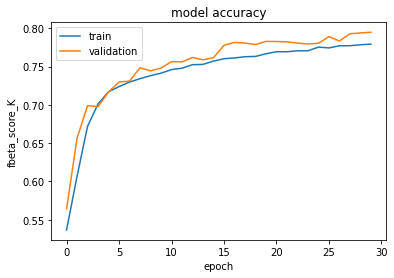

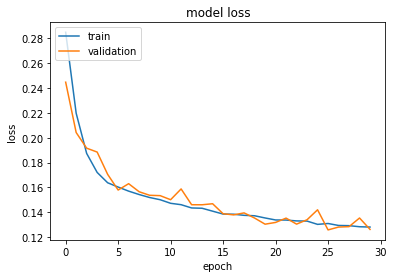

Test Accuracy Score 0.8717155303254768


In [28]:
plot(history.history,'CNN_C_train_history.csv')
print("Test Accuracy Score",calc_acc(y_pred,df_test))

### D. CNN_Baseline + Haze Removal + Data Augmentation + Drop out + Early Stopping

In [29]:
train_generator, val_generator, test_generator = data_generator(X_train_files_o, y_train_o,0)

model_path = 'CNN_D_weights' + '.h5'


adam = Adam(learning_rate=LR)

cnn_dropout_model = dropout.create_model()

clear_session()

cnn_dropout_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[fbeta_score_K])

callbacks = [
    ModelCheckpoint(model_path, monitor='val_fbeta_score_K', save_best_only=True, mode='max'),
    ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, mode='min', min_lr=0.000001),
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5),
]

history = cnn_dropout_model.fit(train_generator, epochs=EPOCHS, validation_data=val_generator, callbacks=callbacks,
                   workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)

print('here', history.history.keys())

cnn_dropout_model.load_weights(model_path)

y_pred = cnn_dropout_model.predict(test_generator, workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)

Found 25906 validated image filenames belonging to 17 classes.
Found 6477 validated image filenames belonging to 17 classes.
Found 8096 validated image filenames belonging to 17 classes.
Epoch 1/30
203/203 [==============================] - 40s 184ms/step - loss: 0.3679 - fbeta_score_K: 0.4930 - val_loss: 0.2440 - val_fbeta_score_K: 0.5684
Epoch 2/30
203/203 [==============================] - 41s 197ms/step - loss: 0.2313 - fbeta_score_K: 0.5877 - val_loss: 0.2058 - val_fbeta_score_K: 0.6279
Epoch 3/30
203/203 [==============================] - 42s 198ms/step - loss: 0.1985 - fbeta_score_K: 0.6497 - val_loss: 0.1805 - val_fbeta_score_K: 0.6942
Epoch 4/30
203/203 [==============================] - 41s 196ms/step - loss: 0.1777 - fbeta_score_K: 0.6920 - val_loss: 0.1657 - val_fbeta_score_K: 0.7196
Epoch 5/30
203/203 [==============================] - 41s 193ms/step - loss: 0.1670 - fbeta_score_K: 0.7118 - val_loss: 0.1628 - val_fbeta_score_K: 0.7163
Epoch 6/30
203/203 [==================

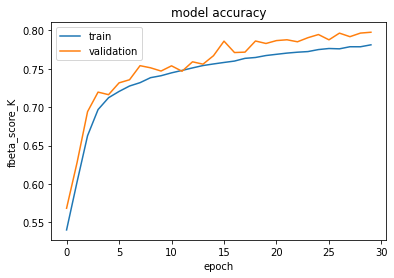

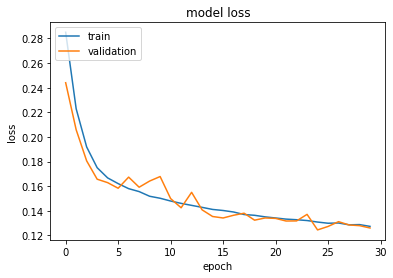

Test Accuracy Score 0.8735704379873037


In [31]:
plot(history.history,'CNN_D_train_history.csv')
print("Test Accuracy Score",calc_acc(y_pred,df_test))

### E. CNN_Baseline + Haze Removal + Data Augmentation + Batch Normalization + Drop out + Early Stopping

In [32]:
train_generator, val_generator, test_generator = data_generator(X_train_files_o, y_train_o,0)

model_path = 'CNN_E_weights' + '.h5'


adam = Adam(learning_rate=LR)

cnn_batch_model = batchN.create_model()

clear_session()

cnn_batch_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[fbeta_score_K])

callbacks = [
    ModelCheckpoint(model_path, monitor='val_fbeta_score_K', save_best_only=True, mode='max'),
    ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, mode='min', min_lr=0.000001),
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5),
]

history = cnn_batch_model.fit(train_generator, epochs=EPOCHS, validation_data=val_generator, callbacks=callbacks,
                   workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)

print('here', history.history.keys())

cnn_batch_model.load_weights(model_path)

y_pred = cnn_batch_model.predict(test_generator, workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)

Found 25906 validated image filenames belonging to 17 classes.
Found 6477 validated image filenames belonging to 17 classes.
Found 8096 validated image filenames belonging to 17 classes.
Epoch 1/30
203/203 [==============================] - 41s 191ms/step - loss: 0.2452 - fbeta_score_K: 0.6112 - val_loss: 0.3463 - val_fbeta_score_K: 0.3931
Epoch 2/30
203/203 [==============================] - 41s 195ms/step - loss: 0.1750 - fbeta_score_K: 0.6985 - val_loss: 0.3204 - val_fbeta_score_K: 0.4684
Epoch 3/30
203/203 [==============================] - 41s 196ms/step - loss: 0.1601 - fbeta_score_K: 0.7267 - val_loss: 0.2103 - val_fbeta_score_K: 0.5986
Epoch 4/30
203/203 [==============================] - 41s 197ms/step - loss: 0.1528 - fbeta_score_K: 0.7395 - val_loss: 0.1504 - val_fbeta_score_K: 0.7377
Epoch 5/30
203/203 [==============================] - 41s 195ms/step - loss: 0.1469 - fbeta_score_K: 0.7492 - val_loss: 0.1644 - val_fbeta_score_K: 0.6995
Epoch 6/30
203/203 [==================

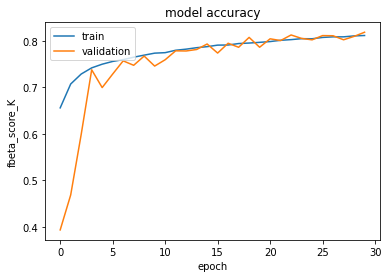

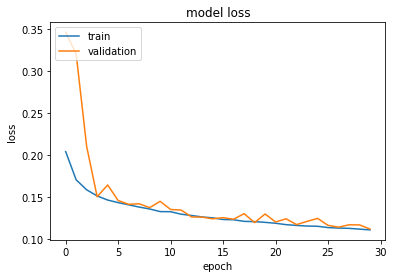

Test Accuracy Score 0.888352588275605


In [33]:
plot(history.history,'CNN_E_train_history.csv')
print("Test Accuracy Score",calc_acc(y_pred,df_test))

### F. MobileNet + Haze Removal + Data Augmentation + Early Stopping

In [37]:
train_generator, val_generator, test_generator = data_generator(X_train_files_o, y_train_o,0)

model_path = 'CNN_F_weights' + '.h5'


adam = Adam(learning_rate=LR)

mobnet_model = mobnet.create_model()

clear_session()
mobnet_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[fbeta_score_K])

callbacks = [
    ModelCheckpoint(model_path, monitor='val_fbeta_score_K', save_best_only=True, mode='max'),
    ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, mode='min', min_lr=0.000001),
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
]

history = mobnet_model.fit(train_generator, epochs=EPOCHS, validation_data=val_generator, callbacks=callbacks,
                   workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)

print('here', history.history.keys())

mobnet_model.load_weights(model_path)

y_pred = mobnet_model.predict(test_generator, workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)


Found 25906 validated image filenames belonging to 17 classes.
Found 6477 validated image filenames belonging to 17 classes.
Found 8096 validated image filenames belonging to 17 classes.
Epoch 1/30
203/203 [==============================] - 45s 201ms/step - loss: 0.3061 - fbeta_score_K: 0.6440 - val_loss: 0.1619 - val_fbeta_score_K: 0.7757
Epoch 2/30
203/203 [==============================] - 44s 210ms/step - loss: 0.1218 - fbeta_score_K: 0.8001 - val_loss: 0.1141 - val_fbeta_score_K: 0.8252
Epoch 3/30
203/203 [==============================] - 44s 205ms/step - loss: 0.1128 - fbeta_score_K: 0.8133 - val_loss: 0.1072 - val_fbeta_score_K: 0.8348
Epoch 4/30
203/203 [==============================] - 43s 206ms/step - loss: 0.1067 - fbeta_score_K: 0.8216 - val_loss: 0.1063 - val_fbeta_score_K: 0.8406
Epoch 5/30
203/203 [==============================] - 45s 213ms/step - loss: 0.1013 - fbeta_score_K: 0.8293 - val_loss: 0.0997 - val_fbeta_score_K: 0.8374
Epoch 6/30
203/203 [==================

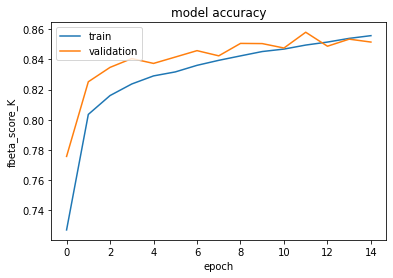

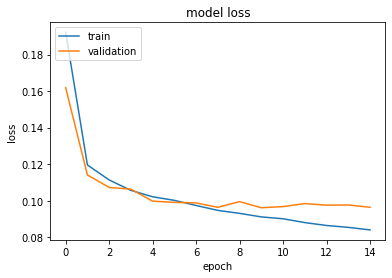

Test Accuracy Score 0.9045989919429571


In [38]:
plot(history.history,'CNN_F_train_history.csv')
print("Test Accuracy Score",calc_acc(y_pred,df_test))

### G. VGG16 + Haze Removal + Data Augmentation + Early Stopping

In [39]:
train_generator, val_generator, test_generator = data_generator(X_train_files_o, y_train_o,0)

model_path = 'CNN_G_weights' + '.h5'


adam = Adam(learning_rate=LR)

vgg16_model = vgg16.create_model()

clear_session()
vgg16_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[fbeta_score_K])

callbacks = [
    ModelCheckpoint(model_path, monitor='val_fbeta_score_K', save_best_only=True, mode='max'),
    ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, mode='min', min_lr=0.000001),
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
]

history = vgg16_model.fit(train_generator, epochs=EPOCHS, validation_data=val_generator, callbacks=callbacks,
                   workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)

print('here', history.history.keys())

vgg16_model.load_weights(model_path)

y_pred = vgg16_model.predict(test_generator, workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)


Found 25906 validated image filenames belonging to 17 classes.
Found 6477 validated image filenames belonging to 17 classes.
Found 8096 validated image filenames belonging to 17 classes.
Epoch 1/30
203/203 [==============================] - 47s 214ms/step - loss: 0.3371 - fbeta_score_K: 0.6182 - val_loss: 0.1574 - val_fbeta_score_K: 0.7715
Epoch 2/30
203/203 [==============================] - 44s 212ms/step - loss: 0.1219 - fbeta_score_K: 0.7991 - val_loss: 0.1121 - val_fbeta_score_K: 0.8301
Epoch 3/30
203/203 [==============================] - 45s 214ms/step - loss: 0.1128 - fbeta_score_K: 0.8124 - val_loss: 0.1034 - val_fbeta_score_K: 0.8328
Epoch 4/30
203/203 [==============================] - 45s 212ms/step - loss: 0.1062 - fbeta_score_K: 0.8233 - val_loss: 0.1045 - val_fbeta_score_K: 0.8422
Epoch 5/30
203/203 [==============================] - 45s 215ms/step - loss: 0.1009 - fbeta_score_K: 0.8296 - val_loss: 0.1012 - val_fbeta_score_K: 0.8433
Epoch 6/30
203/203 [==================

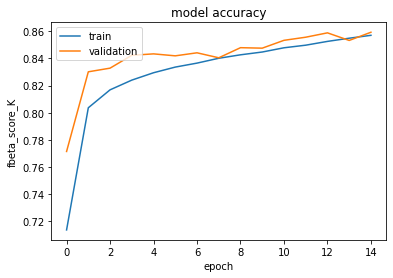

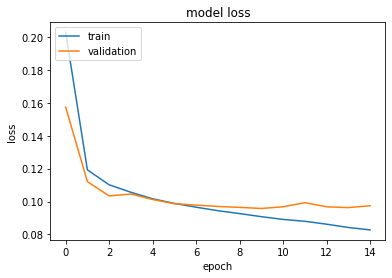

Test Accuracy Score 0.90723752005681


In [40]:
plot(history.history,'CNN_G_train_history.csv')
print("Test Accuracy Score",calc_acc(y_pred,df_test))

### XGBoost

In [41]:
import numpy as np
import os
import pandas as pd
import random
from tqdm import tqdm
import xgboost as xgb
import scipy
from sklearn.metrics import fbeta_score
from PIL import Image

In [42]:
# Set the seed 
random_seed = 1
random.seed(random_seed)
np.random.seed(random_seed)

In [43]:
# Function to extract the image features
def extract_features(df, data_path):
    im_features = df.copy()

    N = len(im_features.image_name.values)

    r_mean = np.zeros(N)
    g_mean = np.zeros(N)
    b_mean = np.zeros(N)

    r_std = np.zeros(N)
    g_std = np.zeros(N)
    b_std = np.zeros(N)

    r_max = np.zeros(N)
    g_max = np.zeros(N)
    b_max = np.zeros(N)

    r_min = np.zeros(N)
    g_min = np.zeros(N)
    b_min = np.zeros(N)

    r_kurtosis = np.zeros(N)
    g_kurtosis = np.zeros(N)
    b_kurtosis = np.zeros(N)
    
    r_skewness = np.zeros(N)
    g_skewness = np.zeros(N)
    b_skewness = np.zeros(N)

    for i, image_name in enumerate(tqdm(im_features.image_name.values, miniters=1000)): 
        im = Image.open(data_path + image_name)
        im = np.array(im)[:,:,:3]

        r = im[:,:,0].ravel()
        g = im[:,:,1].ravel()
        b = im[:,:,2].ravel()
        
        r_mean[i] = np.mean(r)
        g_mean[i] = np.mean(g)
        b_mean[i] = np.mean(b)

        r_std[i] = np.std(r)
        g_std[i] = np.std(g)
        b_std[i] = np.std(b)

        r_max[i] = np.max(r)
        g_max[i] = np.max(g)
        b_max[i] = np.max(b)

        r_min[i] = np.min(r)
        g_min[i] = np.min(g)
        b_min[i] = np.min(b)

        r_kurtosis[i] = scipy.stats.kurtosis(r)
        g_kurtosis[i] = scipy.stats.kurtosis(g)
        b_kurtosis[i] = scipy.stats.kurtosis(b)
        
        r_skewness[i] = scipy.stats.skew(r)
        g_skewness[i] = scipy.stats.skew(g)
        b_skewness[i] = scipy.stats.skew(b)


    im_features['r_mean'] = r_mean
    im_features['g_mean'] = g_mean
    im_features['b_mean'] = b_mean

    im_features['rgb_mean_mean'] = (r_mean + g_mean + b_mean)/3.0

    im_features['r_std'] = r_std
    im_features['g_std'] = g_std
    im_features['b_std'] = b_std

    im_features['rgb_mean_std'] = (r_std + g_std + b_std)/3.0

    im_features['r_max'] = r_max
    im_features['g_max'] = g_max
    im_features['b_max'] = b_max

    im_features['rgb_mean_max'] = (r_max + r_max + b_max)/3.0

    im_features['r_min'] = r_min
    im_features['g_min'] = g_min
    im_features['b_min'] = b_min

    im_features['rgb_mean_min'] = (r_min + g_min + b_min)/3.0

    im_features['r_range'] = r_max - r_min
    im_features['g_range'] = g_max - g_min
    im_features['b_range'] = b_max - b_min

    im_features['r_kurtosis'] = r_kurtosis
    im_features['g_kurtosis'] = g_kurtosis
    im_features['b_kurtosis'] = b_kurtosis
    
    im_features['r_skewness'] = r_skewness
    im_features['g_skewness'] = g_skewness
    im_features['b_skewness'] = b_skewness
    
    return im_features

In [44]:
# Extract features
print('Extracting train features')
train_features = extract_features(df_train,TRAIN_PATH+"/")
print('Extracting test features')
test_features = extract_features(df_test,TEST_PATH+"/")

  0%|          | 0/32383 [00:00<?, ?it/s]

Extracting train features


  0%|          | 0/8096 [00:00<?, ?it/s]

Extracting test features


100%|██████████| 8096/8096 [01:02<00:00, 130.47it/s]


In [45]:
# pickle the data

import pickle
train_feat = open('train_features_xgb.pickle', 'wb')
pickle.dump(train_features, train_feat, protocol=4)
train_feat.close()

test_feat = open('test_features_xgb.pickle', 'wb')
pickle.dump(test_features, test_feat, protocol=4)
test_feat.close()

In [46]:
#load the pickled features:
import pickle
pickle_XGtrain = open('train_features_xgb.pickle', 'rb')
train_features = pickle.load(pickle_XGtrain)

pickle_yGtrain = open('test_features_xgb.pickle', 'rb')
test_features = pickle.load(pickle_yGtrain)

In [47]:
# Prepare data
X = np.array(train_features.drop(['image_name', 'tags'], axis=1))
y_train = []

flatten = lambda l: [item for sublist in l for item in sublist]
labels = np.array(list(set(flatten(train_features['tags'].values))))
#np.array(list(set(flatten([l.split(' ') for l in train_features['tags'].values]))))

label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}

In [48]:
#print(labels)

In [50]:
#inv_label_map

In [51]:
#label_map

In [53]:
#train_features['tags']
#df_train.tags.values

In [48]:
for tags in tqdm(df_train.tags.values, miniters=1000):
    targets = np.zeros(17)
    for t in tags:
        targets[label_map[t]] = 1 
    y_train.append(targets)
    
y = np.array(y_train, np.uint8)

100%|██████████| 32383/32383 [00:00<00:00, 483961.03it/s]


In [49]:
print('X.shape = ' + str(X.shape))
print('y.shape = ' + str(y.shape))

X.shape = (32383, 25)
y.shape = (32383, 17)


In [50]:
print(y[4])

[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0]


In [51]:
n_classes = y.shape[1]

#Create X train and test dataset

X_test = np.array(test_features.drop(['image_name', 'tags'], axis=1))
X_train = np.array(train_features.drop(['image_name', 'tags'], axis=1))

In [52]:
print(X_test.shape)

(8096, 26)


In [53]:
print(X_train.shape)

(32383, 25)


In [54]:
# Train and predict with one-vs-all strategy
y_pred = np.zeros((X_test.shape[0], n_classes))
train_pred = np.zeros((X_train.shape[0], n_classes))

In [56]:
# print('Wait for it ....')
# for class_i in tqdm(range(n_classes), miniters=1): 
#     model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=100, \
#                               silent=True, objective='binary:logistic', nthread=-1, \
#                               gamma=0, min_child_weight=1, max_delta_step=0, \
#                               subsample=1, colsample_bytree=1, colsample_bylevel=1, \
#                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, \
#                               base_score=0.5, seed=random_seed)
#     model.fit(X, y[:, class_i])
#     y_pred[:, class_i] = model.predict_proba(X_test)[:, 1]
#     train_pred[:, class_i] = model.predict_proba(X_train)[:, 1]

In [57]:
for class_i in tqdm(range(n_classes), miniters=1):
    print("class_i =", class_i, inv_label_map[class_i])
    model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=100, \
                              objective='binary:logistic', n_jobs=-1, \
                              gamma=0, min_child_weight=1, max_delta_step=0, \
                              subsample=1, colsample_bytree=1, colsample_bylevel=1, \
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, \
                              base_score=0.5, seed=random_seed, \
                              use_label_encoder=False, eval_metric='error', \
                             )
   
    model.fit(X_train, y_train[:, class_i])
    train_pred[:, class_i] = model.predict_proba(X_train)[:,1] # prediction on train set
    y_pred[:, class_i] = model.predict_proba(X_test)[:,1] # prediction on test set

  0%|          | 0/17 [00:00<?, ?it/s]

class_i = 0 road


TypeError: list indices must be integers or slices, not tuple

In [ ]:
#print(model.predict_proba(X_test))

In [ ]:
train_pred.shape

In [ ]:
xg_results = pd.DataFrame(y_pred, columns = labels)
xg_results[:10]

In [ ]:
xg_train_res = pd.DataFrame(train_pred, columns = labels)
xg_train_res[:10]

In [ ]:
xg_results.to_csv('result_xgb_0.3.csv', index=False)

In [ ]:
res = open('result_xgb_0.5.pickle', 'wb')
pickle.dump(xg_results, res, protocol=4)
res.close()

In [ ]:
#Check predicted rare labels
print("Blow downs: ",len(xg_results[xg_results['blow_down']>0.2]))
print("conventional_mine: ",len(xg_results[xg_results['conventional_mine']>0.2]))
print("selective_logging: ",len(xg_results[xg_results['selective_logging']>0.2]))
print("slash_burn: ",len(xg_results[xg_results['slash_burn']>0.2]))
print("Cultivation: ",len(xg_results[xg_results['cultivation']>0.2]))

In [ ]:
#create prediction flag
preds = [' '.join(labels[y_pred_row > 0.2]) for y_pred_row in y_pred]

In [ ]:
#Create a  dataframe wiht test images and labels 
subm = pd.DataFrame()
subm['image_name'] = test_features.image_name.values
subm['tags'] = preds
subm[:10]

In [ ]:
#Create flags for prediction flags
train_preds = [' '.join(labels[y_pred_row > 0.2]) for y_pred_row in train_pred]

In [ ]:
#Create a  dataframe wiht train images and labels 
trainfrm = pd.DataFrame()
trainfrm['image_name'] = train_features.image_name.values
trainfrm['pred_tags'] = train_preds
trainfrm[:10]